In [1]:
import cv2
from PIL import Image 
import time

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)
import numpy as np
import math
import os
os.chdir("../")
from tools.image import draw_umich_gaussian

In [5]:
def get_gaussian_weight(w, h, radius):
    heat = np.zeros((h, w))
    gaussian = draw_umich_gaussian(heat, (w//2-1,h//2-1), int(radius)).T
    return gaussian

def get_ellipse_angle(vec):
    vec = vec / (np.linalg.norm(vec, axis=0, keepdims=True) + 1e-6)
    quadrant_x, quadrant_y = vec > 0
    phi = (np.arccos(-vec[0]) / math.pi * 180).astype(int)
    phi = np.clip(phi, 0, 360)
    if quadrant_x > 0:
        if quadrant_y > 0:  
            angle = 360 - phi
        else:
            angle = phi
    else:
        if quadrant_y > 0:  
            angle = -phi
        else:
            angle = phi
    return angle

def get_ellipse_end_angle(end, vec1, vec2):
    vec1 = vec1 / (np.linalg.norm(vec1, axis=0, keepdims=True) + 1e-6)
    vec2 = vec2 / (np.linalg.norm(vec2, axis=0, keepdims=True) + 1e-6) 
    theta = (np.arccos(np.dot(vec1, vec2)) / math.pi * 180).astype(int) 
    theat = np.clip(theta, 0, 360)
    det = np.linalg.det(np.vstack([vec1, vec2]))
    if det > 0:
        end_angle = 180 + theta
    elif det < 0:
        end_angle = 180 - theta
    else:
        end_angle = 180
    return end_angle

def build_lines(pts, is_ploygon):
    assert pts.ndim == 2
    assert pts.shape[1] == 2
    assert pts.shape[0] > 1
    lines = np.hstack([pts, np.vstack([pts[1:], pts[0]])]).reshape((-1,2,2))
    if not is_ploygon:
        return lines[:-1]
    return lines

def build_segments(pts, lines, w, h, gaussian_weight, max_radius, debug=True):
    traces = []
    planks = []
    for line_idx, line_pt in enumerate(lines):
        start, end = line_pt
        num_pt = np.linalg.norm(end-start, axis=0).astype(int)
        traces.append(np.linspace(start, end, num_pt))
    for trace in traces:
        trace = np.concatenate([trace[:-2], trace[1:-1], trace[2:]], axis=1).reshape(-1, 3, 2)
        plank = np.ones((h,w)).astype(np.uint8) * 255
        for start, middle, end in trace:
            x, y = middle.astype(int)
            vec1 = middle - start
            vec2 = end - middle
            angle = get_ellipse_angle(vec1)
            end_angle = get_ellipse_end_angle(end, vec1, vec2)          
            weight = gaussian_weight[x, y]
            radius = max_radius * weight
            cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle, 0, end_angle, 0, -1)
            cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+end_angle, 0, 360-end_angle, 1, -1)
        start, middle, end = trace[0]
        x, y = middle.astype(int)
        vec1 = middle - start
        vec2 = end - middle
        angle = get_ellipse_angle(vec1)
        end_angle = get_ellipse_end_angle(end, vec1, vec2)          
        radius = max(w, h)
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle, 0, end_angle//2, 255, -1)
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+int(end_angle*1.5), 0, 360-end_angle, 255, -1)
        start, middle, end = trace[-1]
        x, y = middle.astype(int)
        vec1 = middle - start
        vec2 = end - middle
        angle = get_ellipse_angle(vec1)
        end_angle = get_ellipse_end_angle(end, vec1, vec2)          
        radius = max(w, h)
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+end_angle//2, 0, end_angle//2, 255, -1)
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+end_angle, 0, (360-end_angle)//2, 255, -1)
        if debug:
            start, _, _ = trace[0]
            cv2.circle(plank, (int(start[0]), int(start[1])), 10, 10, -1)
        total = np.zeros((w,h))
        total[plank.T==255] = -1
        total[plank.T==1] = 1
        planks.append(total)
    return planks

def build_polygon(lines, w, h, gaussian_weight, max_radius):
    regions = []
    # planks = []
    for line_idx, line_pt in enumerate(lines):
        region = np.ones((w,h)) * -1
        plank = np.ones((h,w)).astype(np.uint8) * 255
        start, end = line_pt
        vec1 = end-start
        trace = np.linspace(start, end, 50).astype(int)
        for pt in trace:
            x, y = pt
            weight = gaussian_weight[x, y]
            radius = max_radius * weight
            cv2.circle(plank, (x, y), int(radius), (1), -1)    
        y_pts, x_pts = np.where(plank[...,:]==1)
        for x, y in zip(x_pts, y_pts):
            vec2 = np.array([x, y]) - start
            det = np.linalg.det(np.vstack([vec1, vec2]))
            if det > 0:
                region[x,y] = 0
            elif det < 0:
                region[x,y] = 2
            else:
                region[x,y] = 2
        regions.append(region)
    
    regions = np.array(regions)
    assert len(regions) > 2
    w, h = regions.shape[1:]
    num = len(regions)
    closed = np.ones((h,w)).astype(np.uint8) * 255
    closed = cv2.resize(closed, (w, h))
    pts = lines[:,0].astype(np.int32)
    cv2.fillPoly(closed, [pts], (1,1,1))
    closed = np.transpose(closed, (1,0))
    overlap = regions.sum(axis=0)
    # outer region
    total = np.zeros((w,h))
    # ignore region
    total[overlap==-num] = -1
    # inner region
    total[closed==1] = 1
    return total

def build_region_maps(pts, w, h, radius, max_radius, is_ploygon):
    gaussian_weight = get_gaussian_weight(w, h, radius)
    lines = build_lines(pts, is_ploygon)
    if is_ploygon:
        return np.array([build_polygon(lines, w, h, gaussian_weight, max_radius)])
    else:
        return np.array(build_segments(pts, lines, w, h, gaussian_weight, max_radius))

def visualize_region(region_map):
    w, h = region_map.shape
    plain = np.ones((w,h,3))*255
    plain[region_map==-1,:] = 0
    plain[region_map==0,:] = np.array([255,255,0])
    plain[region_map==1,:] = np.array([0,0,255])
    dist = np.transpose(plain, (1,0,2)).astype(np.uint8)
    return to_pil(dist)


In [2]:
region_maps = np.load("/home/acer/Documents/Counting/result/region_maps.npy")

In [75]:
region_map.shape

(1, 1920, 1920)

In [91]:
r = 500
ptss=[
    [[920-r,1032],
        [920,1032]],
    [[920,1032],
        [920+r,1032]],
    [[920,1032],
        [920+r,1032+r]],
    [[920,1032],
        [920,1032-r]]
]
region_map = build_region_maps(np.array(ptss[2]), 1920, 1920, 1920/1.5, 1920//5, False)
img = visualize_region(region_map[0])
np_img = np.array(img)

In [3]:
orig = cv2.imread("/media/acer/5f45949f-0fc7-4475-965b-e61989afcc10/FlowInc_data/counting/03_20200419170000.jpg")

In [9]:
for i in range(len(region_maps)):
    img = visualize_region(region_maps[i])
    orig = cv2.imread("/media/acer/5f45949f-0fc7-4475-965b-e61989afcc10/FlowInc_data/Yilan_03/03_20200419170000.jpg")
    worig = cv2.addWeighted(orig, 0.7, np.array(img), 0.3, 0)
    to_pil(worig).save(f"/home/acer/Documents/Counting/result/R{i}.jpg")

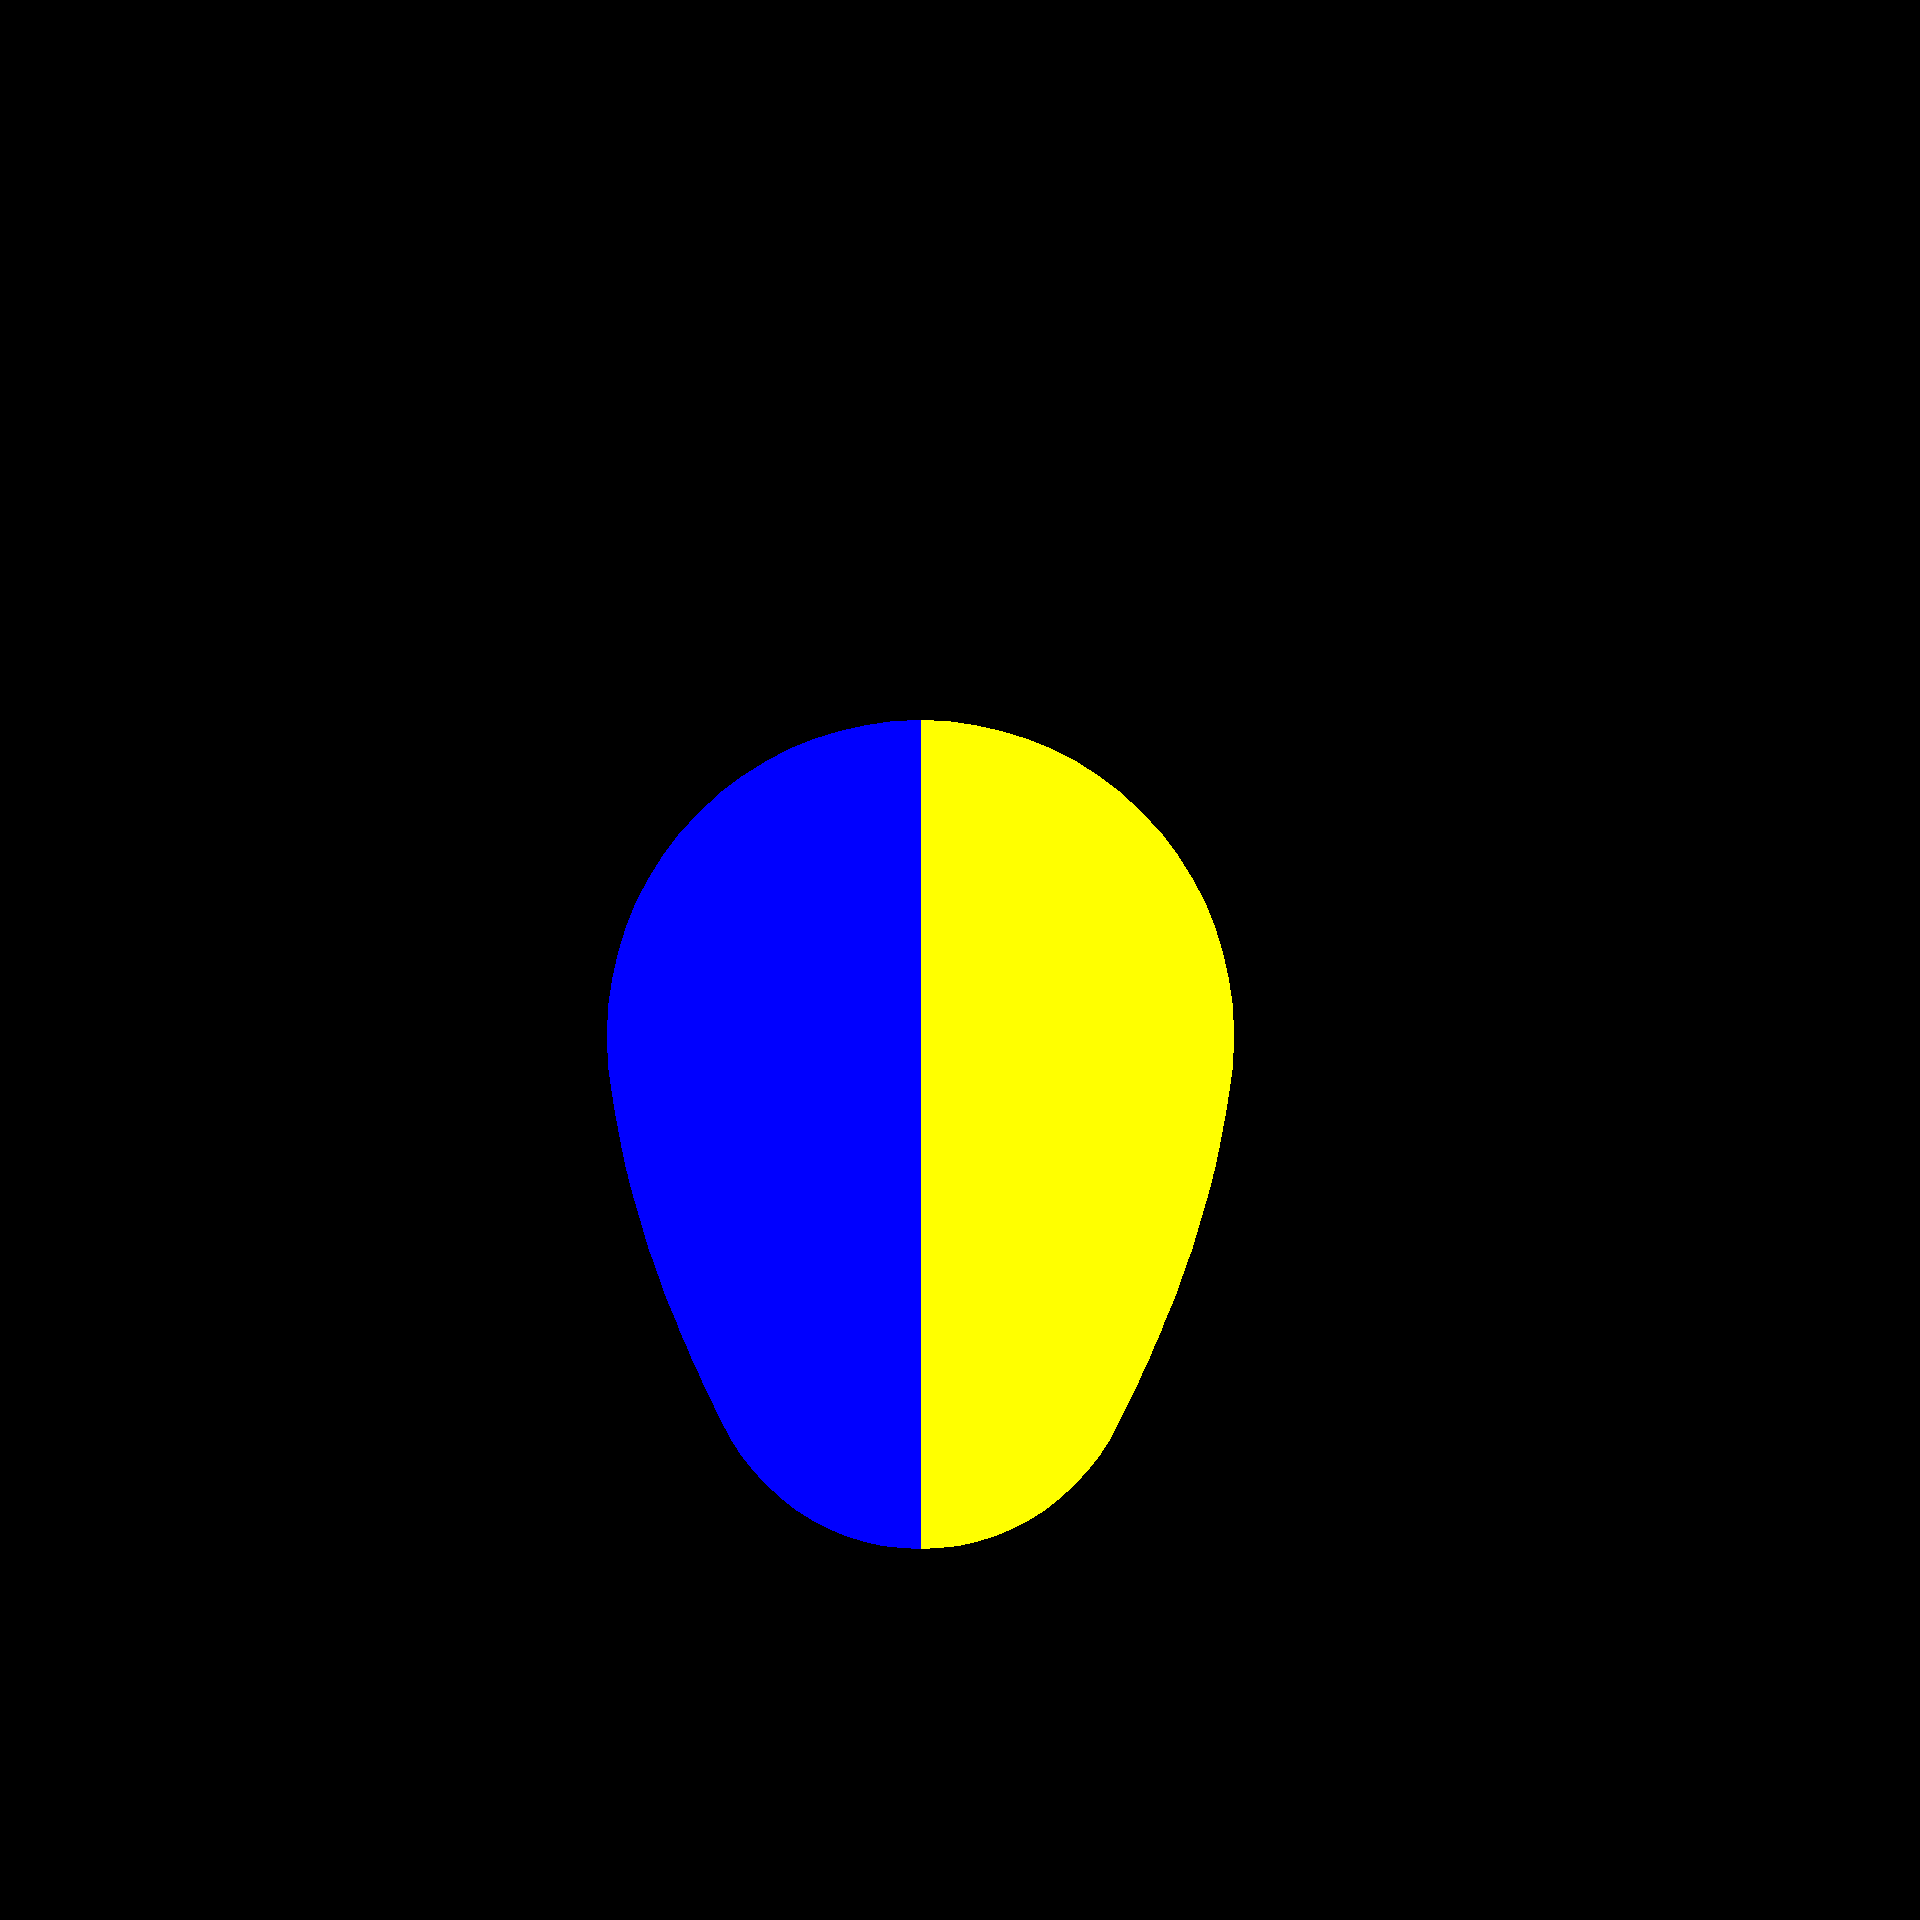

In [55]:
to_pil(np_img)

In [17]:
plank[0].shape

(1920,)

In [52]:
(plank[479]==0).sum()

31

In [53]:
np.where(plank[479]==0)[0]

array([886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898,
       899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911,
       912, 913, 914, 915, 916])

In [68]:
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [72]:
for pixel_x in tqdm(np.where(plank==0)[0]):
    for pixel_y in np.where(plank[pixel_x]==0)[0]:
        pt = np.array([pixel_x, pixel_y])
        idx = np.argmin(cdist(np.array([pt]), pts))
        pt1 = pts[idx]
        if idx + 1 > len(pt):
            pt2 = pts[idx-1]
        else:
            pt2 = pts[idx+1]
        det = np.linalg.det(np.vstack([pt2-pt1, pt-pt1]))
        if det > 0:
            plank[pixel_x, pixel_y] = 0
        elif det < 0:
            plank[pixel_x, pixel_y] = 1
        # else:
        #     plank[pt] = 1


  1%|          | 6175/619517 [01:09<2:33:31, 66.58it/s]

KeyboardInterrupt: 

In [64]:
plank[pixel_x, pixel_y]

0.0

In [37]:
np.argmin(cdist(np.array([pt]), pts))

0

In [85]:
np.array([img[0], img[2]]).shape

(2, 2560, 1920)

In [86]:
np.save("/home/allen/test_region.npy", np.array([img[0], img[2]]))

In [95]:
np.load("/media/allen/mass/deep-learning-works/external/R0.npy")

array([['2020/05/05 14:02:54', '1588658574.113491', '0', '1'],
       ['2020/05/05 14:02:54', '1588658574.526354', '0', '2'],
       ['2020/05/05 14:02:56', '1588658576.175492', '1', '1'],
       ['2020/05/05 14:02:56', '1588658576.516539', '1', '2'],
       ['2020/05/05 14:03:09', '1588658589.584992', '0', '3'],
       ['2020/05/05 14:03:11', '1588658591.295671', '1', '3'],
       ['2020/05/05 14:03:20', '1588658600.803921', '0', '4']],
      dtype='<U19')